Notebook for the Kaggle competition.
Team: Alba/Claudia
Team mates: Alba García and Claudia Valverde

In [1]:
#connect to Drive to retrieve data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#set all necessary imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import missingno as msno

from sklearn import model_selection
from sklearn import metrics

# PROBLEM A - SKIN LESSIONS DATA

Next, we will show the data analysis that we have done and the different approches followed for the preprocessing of the data in problem A.

In [3]:
# loading data
data_A = pd.read_csv('drive/Shareddrives/ML_Kaggle/train_A_derma.csv', sep = ',', index_col='Id', header='infer')
data_A

,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,Doughnuts consumption,Fake/Real
Id,,,,,,,,,,,,
0,1.0,-1.27713,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,1.234125,real
1,NaN,-1.84207,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1.216756,real
2,NaN,-1.82290,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,1.264342,real
3,1.0,-1.36049,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.126842,real
4,NaN,NaN,2.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.198014,fake
...,...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,-2.16422,NaN,1.0,0.0,NaN,0.0,0.0,NaN,0.0,0.217172,fake
593,0.0,NaN,3.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.165209,real
594,0.0,-1.03834,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.165564,real


## ANALYSIS OF THE DATA

In this section we will do some preliminary observations to see what we will need to focus on later (when preprocissing the data).

### General metrics

Describing general metrics of the data.




In [4]:
data_A.describe()

,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,Doughnuts consumption
count,407.000000,403.000000,422.000000,420.000000,413.000000,424.000000,417.000000,422.000000,413.000000,407.000000,597.000000
mean,0.115479,-1.883260,3.106635,0.390476,0.322034,0.127358,0.196643,0.251185,0.336562,0.385749,0.573894
std,0.319993,0.576935,0.783138,0.488439,0.467823,0.333768,0.397937,0.434209,0.473107,0.487371,0.498375
min,0.000000,-3.420110,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000381
25%,0.000000,-2.164220,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139264
50%,0.000000,-2.164220,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.261398
75%,0.000000,-1.519920,4.000000,1.000000,1.000000,0.000000,0.000000,0.750000,1.000000,1.000000,1.115598
max,1.000000,0.349500,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.298831


### Is it a balanced distribution?

Lookig at the distribution of the data, is it balanced?

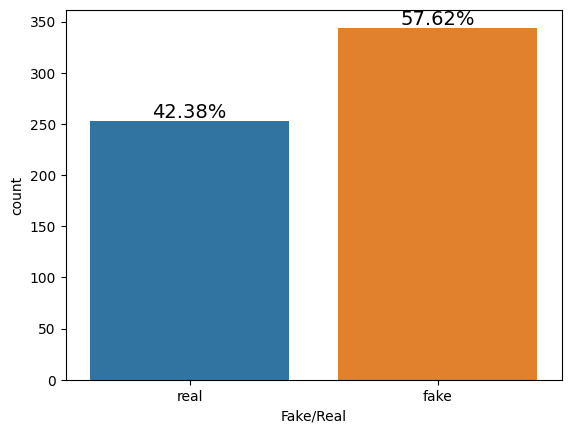

In [5]:
s = sns.countplot(x = 'Fake/Real',data = data_A)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(data_A)*100),
            ha="center", fontsize=14)

In [6]:
#count number of fakes/reals
p = data_A['Fake/Real'].value_counts()

print('fakes:', p[0])
print('reals:', p[1])
percentaje_f=p[0]/(p[0]+p[1])
percentaje_r=p[1]/(p[0]+p[1])
print('proportion fakes:', percentaje_f)
print('proportion reals:', percentaje_r)

fakes: 344
reals: 253
proportion fakes: 0.576214405360134
proportion reals: 0.423785594639866


We can see that it is more or less balance, with a bit more samples from the fake class.

### NaN count

Let's count the number of NaN values. We can see that there is a lot of NaN values for every feature (exept for Doughnuts consumption). We will need to do something with all this missing data.

In [7]:
# counting number of missing values per column
data_A.isna().sum()

Lession                  190
Genetic Propensity       194
Skin X test              175
Skin color               177
Small size               184
Mid size                 173
Large size               180
Mid                      175
Small                    184
Large                    190
Doughnuts consumption      0
Fake/Real                  0
dtype: int64

We also observe the NaN distribution as we saw in Pill 2. The following graphs just confirm that we have a lot of missing data. The second graph is interesting since we can see there are some samples that have seven features empty. We will eliminate those.

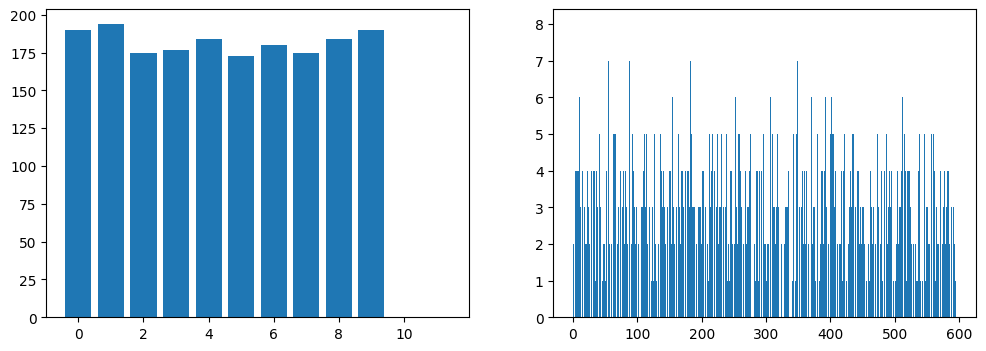

In [17]:
%matplotlib inline

v=np.array(data_pre.values[:,:],dtype=float)

fig = plt.figure()
sf1 = plt.subplot(1,2,1)
year_nan = np.sum(np.where(np.isnan(v),1.,0.),axis=0) # columnwise
plt.bar(np.array(range(year_nan.shape[0])),year_nan)
plt.subplot(1,2,2)
concept_nan = np.sum(np.where(np.isnan(v),1.,0.),axis=1) # rowwise
plt.bar(np.array(range(concept_nan.shape[0])),concept_nan)

fig.set_size_inches((12,4))

### Data types

Looking at the data types of the data: they are all floats, exept for the label 'Fake/Real' that we will change it to '0/1'.

We also look if a column is constant, it has one unique value. It is not the case for this data set.

In [13]:
data_pre = data_A.copy()

In [14]:
# data types and constant values

Univalor=list()
for col in list(data_A):
    l=data_A[col].unique()
    print(len(l),'\t',data_A[col].dtypes,'\t',col)
    if len(l)<=1:
        Univalor.append(col)

3 	 float64 	 Lession
79 	 float64 	 Genetic Propensity
5 	 float64 	 Skin X test
3 	 float64 	 Skin color
3 	 float64 	 Small size
3 	 float64 	 Mid size
3 	 float64 	 Large size
3 	 float64 	 Mid
3 	 float64 	 Small
3 	 float64 	 Large
597 	 float64 	 Doughnuts consumption
2 	 object 	 Fake/Real


In [15]:
# transform fake/real to 0/1

#adds column with data transformed with the name 'YourColumn'
data_pre['YourColumn'] = data_pre['Fake/Real'].map({'fake': 0, 'real': 1})

data_pre = data_pre.drop('Fake/Real', axis = 1) #drop previous column
data_pre = data_pre.rename(columns={'YourColumn': 'Fake/Real'}) #rename new column

data_pre

,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,Doughnuts consumption,Fake/Real
Id,,,,,,,,,,,,
0,1.0,-1.27713,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,1.234125,1
1,NaN,-1.84207,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1.216756,1
2,NaN,-1.82290,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,1.264342,1
3,1.0,-1.36049,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1.126842,1
4,NaN,NaN,2.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.198014,0
...,...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,-2.16422,NaN,1.0,0.0,NaN,0.0,0.0,NaN,0.0,0.217172,0
593,0.0,NaN,3.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.165209,1
594,0.0,-1.03834,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.165564,1


### Distribution for both classes

Now, we want to plot the different distributions of the features. We separete the plot on Real and Fake with the goal of trying to find differences in the distribution of the data.

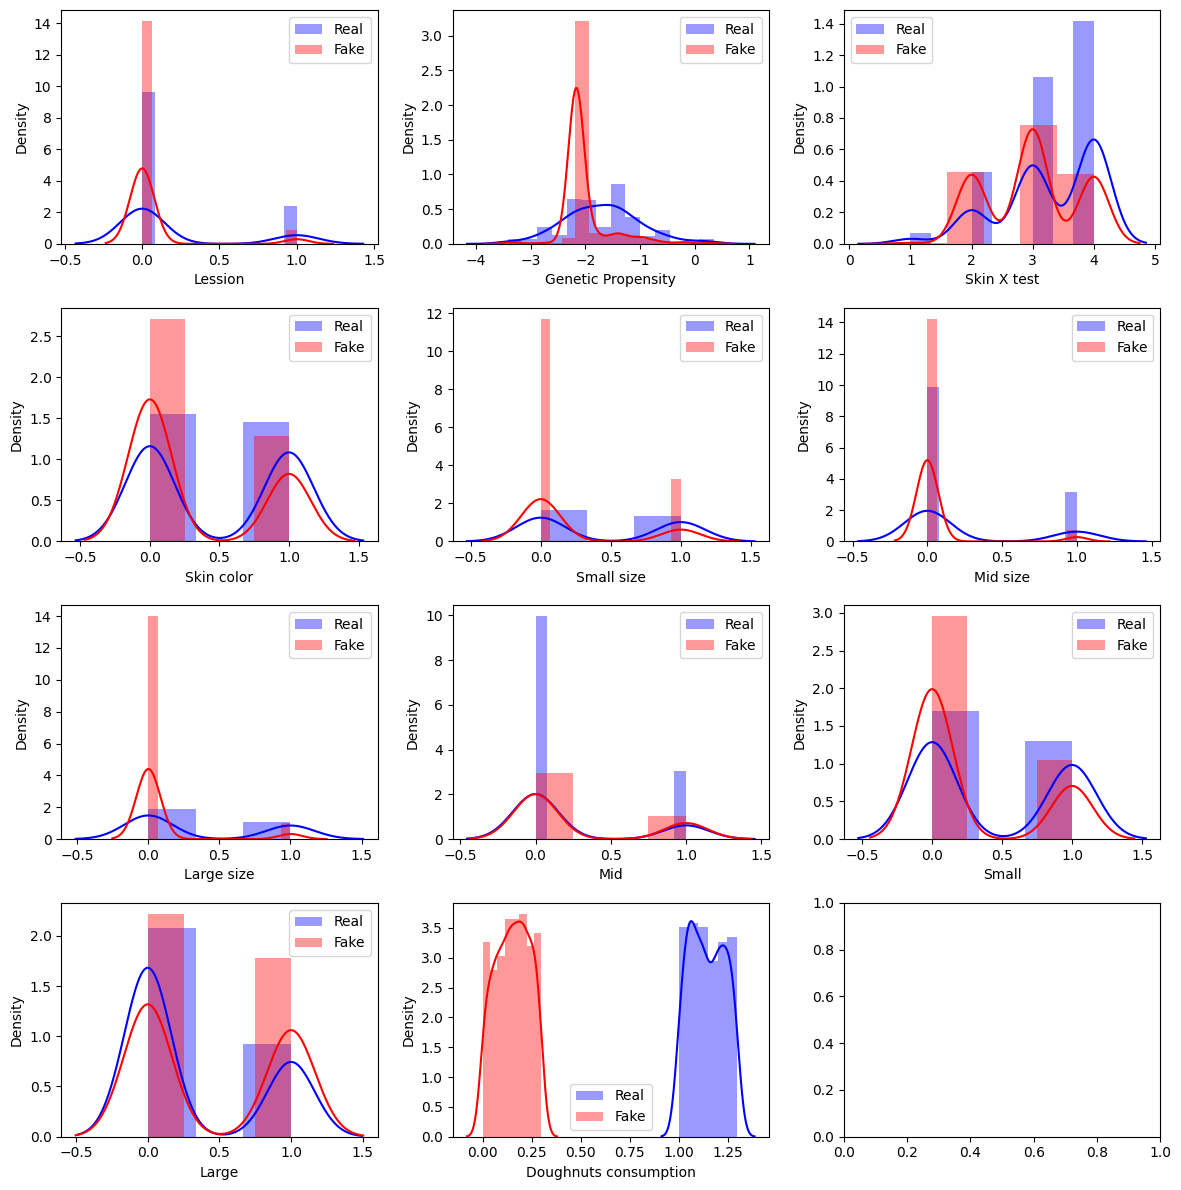

In [ ]:
# Separate real and fake data
real_data = data_A[data_A['Fake/Real'] == 'real']
fake_data = data_A[data_A['Fake/Real'] == 'fake']

# Disable warnings
warnings.filterwarnings("ignore")

# Create subplots for each feature in a 2x4 grid layout
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.ravel()

for i, feature in enumerate(data_A.columns[:-1]):  # Exclude the 'Real/Fake' column
    sns.distplot(real_data[feature], kde=True, label='Real', color='blue', ax=axes[i])
    sns.distplot(fake_data[feature], kde=True, label='Fake', color='red', ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].legend()

# Remove any unused subplots
for i in range(len(data_A.columns) + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

With these plots we can see how in most cases, the distribution of fake samples is similar to the distribution of real samples. We want to focus on the column 'Genetic Propensity' since it seems it's has the most different distribution for both classes.

We also observe the distribution for the feature '**Doughnut consumption**' is really different form the others. Our assumption here is that, this features doesn't come from the same probability distribution that has generated the other features. Because of this, further analysis done previously, we will delete it.

In [ ]:
#eliminate donuts column
data_pre = data_pre.drop('Doughnuts consumption', axis = 1)
data_pre

,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,Fake/Real
Id,,,,,,,,,,,
0,1.0,-1.27713,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,1
1,NaN,-1.84207,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1
2,NaN,-1.82290,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,1
3,1.0,-1.36049,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1
4,NaN,NaN,2.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,-2.16422,NaN,1.0,0.0,NaN,0.0,0.0,NaN,0.0,0
593,0.0,NaN,3.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1
594,0.0,-1.03834,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


### Correlation matrix

Let's find the correlation between the columns. This could help us to see what columns have relations between them.

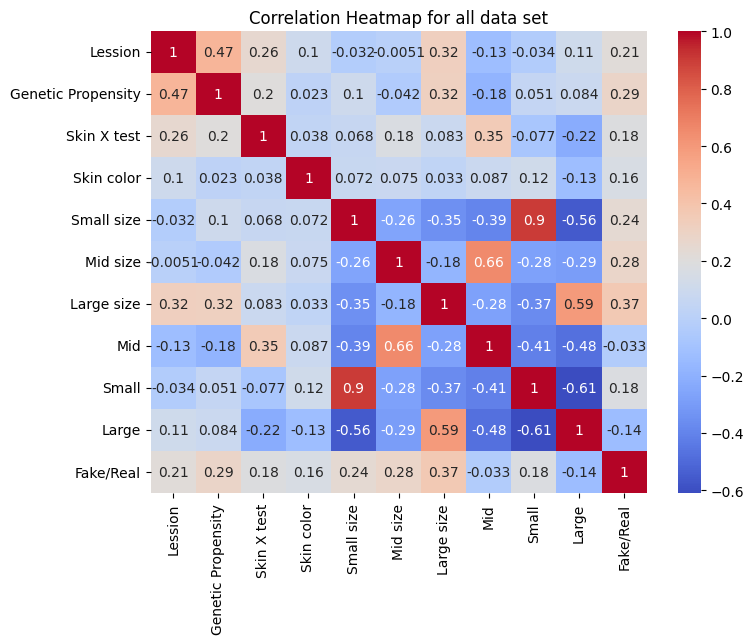

In [ ]:
# Create a correlation matrix
correlation_matrix = data_pre.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap for all data set')
plt.show()

We observe the following things:

* The "size" features (Small size, Mid size, Large size and Small, Mid and Large) are correlated in some way.
* Genetic Propensity and Lession also present some kind of corrrelation.
* None of the features seems to present a strong correlation with the 'Fake/Real' column.

### CONCLUSIONS

The principal problem with this data is the high quantity of NaN values. We will focus on that on the next section, the preprocessing of the data.

## PREPROCESSING

Now that we have studied the data, we will start preprocessing it. We have already done some preprocessing:

* Transformaing 'Fake/Real' into '0/1'
* Eliminating the Doughnuts consumption column.

Next, we will focus on imputing the NaN values for all the columns.

### Imputing NaN's - GP

As we saw before, Genetic Propensity has the most different distributions between the fake class and the real class, that's why we focused a lot in the column at first. We tried a lot of different strategies to filled in the NaN values:

* With the mean
* With the mean of each distribution
* With target encoding
* With a KNN model

At the end, it was the mean that works better.

For the mean, we have two options: fill them with the mean considering the whole column, or with the mean of each distribution. For the second one, we do it at random preserving the proportion of fakes and reals.

In [ ]:
data_gp=data_pre[['Genetic Propensity', 'Fake/Real']]
data_gp

,Genetic Propensity,Fake/Real
Id,,
0,-1.27713,1
1,-1.84207,1
2,-1.82290,1
3,-1.36049,1
4,NaN,0
...,...,...
592,-2.16422,0
593,NaN,1
594,-1.03834,1


Option 1 - Fill with mean

In [ ]:
data_pre['GP_mean']=data_pre['Genetic Propensity'].fillna(data_gp['Genetic Propensity'].mean())

Option 2 - Fill with each distribution mean

In [ ]:
# Create a DataFrame with rows containing NaN in the GP
gp_nans = data_gp[data_gp['Genetic Propensity'].isna()]

# Create a DataFrame with rows without NaN in the GP
gp_no_nans = data_gp[data_gp['Genetic Propensity'].notna()]

In [ ]:
real_gp_nans = gp_nans[gp_nans['Fake/Real'] == 1]
print('Mean of gp_nans real values:', real_gp_nans.mean()[0])
print('Number of real values in gp_nans:', len(real_gp_nans))

fake_gp_nans = gp_nans[gp_nans['Fake/Real'] == 0]
print('Mean of gp_nans fake values:', fake_gp_nans.mean()[0])
print('Number of fake values in gp_nans:', len(fake_gp_nans))

real_gp_no_nans = gp_no_nans[gp_no_nans['Fake/Real'] == 1]
print('Mean of gp_no_nans real values:', real_gp_no_nans.mean()[0])
print('Number of real values in gp_no_nans:', len(real_gp_no_nans))

fake_gp_no_nans = gp_no_nans[gp_no_nans['Fake/Real'] == 0]
print('Mean of gp_no_nans fake values:', fake_gp_no_nans.mean()[0])
print('Number of fake values in gp_no_nans:', len(fake_gp_no_nans))

p_value1 = len(fake_gp_nans)/(len(fake_gp_nans)+len(real_gp_nans))
p_value2 = len(real_gp_nans)/(len(fake_gp_nans)+len(real_gp_nans))
print('\nProbability of fake in GP_NaN:', p_value1)
print('Probability of real in GP_NaN:', p_value2)
print('Probability of fake in GP_no_NaN:', len(fake_gp_no_nans)/(len(fake_gp_no_nans)+len(real_gp_no_nans)))
print('Probability of real in GP_no_NaN:', len(real_gp_no_nans)/(len(fake_gp_no_nans)+len(real_gp_no_nans)))


Mean of gp_nans real values: nan
Number of real values in gp_nans: 81
Mean of gp_nans fake values: nan
Number of fake values in gp_nans: 109
Mean of gp_no_nans real values: -1.6894924824495288
Number of real values in gp_no_nans: 169
Mean of gp_no_nans fake values: -2.025610375262442
Number of fake values in gp_no_nans: 231

Probability of fake in GP_NaN: 0.5736842105263158
Probability of real in GP_NaN: 0.4263157894736842
Probability of fake in GP_no_NaN: 0.5775
Probability of real in GP_no_NaN: 0.4225


We can assume that fake/real are distributed really symilar between NaN's values and non NaN's values. We will now randomly fill in the NaN values using these proportions (`p_value1` and `p_value2`).

In [ ]:
random_values = np.random.choice([-2.026208, -1.68932], size=len(data_gp), p=[p_value1, p_value2]) #take previous probabilities

# GP values if not NaN or the generated random values
data_gp['GP_Filled'] = data_gp['Genetic Propensity'].combine_first(pd.Series(random_values, index=data_gp.index))
data_gp

<ipython-input-23-86b15ea656e3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_gp['GP_Filled'] = data_gp['Genetic Propensity'].combine_first(pd.Series(random_values, index=data_gp.index))


,Genetic Propensity,Fake/Real,GP_Filled
Id,,,
0,-1.27713,1,-1.277130
1,-1.84207,1,-1.842070
2,-1.82290,1,-1.822900
3,-1.36049,1,-1.360490
4,NaN,0,-2.026208
...,...,...,...
592,-2.16422,0,-2.164220
593,NaN,1,-1.689320
594,-1.03834,1,-1.038340


In [ ]:
#join the GP_Filled column to the previous data

data_pre = pd.concat([data_pre, data_gp['GP_Filled']], axis=1)
data_pre

,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,Fake/Real,GP_mean,GP_Filled
Id,,,,,,,,,,,,,
0,1.0,-1.27713,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,1,-1.277130,-1.277130
1,NaN,-1.84207,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1,-1.842070,-1.842070
2,NaN,-1.82290,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,1,-1.822900,-1.822900
3,1.0,-1.36049,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1,-1.360490,-1.360490
4,NaN,NaN,2.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0,-1.883601,-2.026208
...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,-2.16422,NaN,1.0,0.0,NaN,0.0,0.0,NaN,0.0,0,-2.164220,-2.164220
593,0.0,NaN,3.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1,-1.883601,-1.689320
594,0.0,-1.03834,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,-1.038340,-1.038340


### Imputing NaN's - Lession and Skin color

For both of these columns we have tried a great variety of strategies when imputing the NaN values.

*   All 0's
*   All 1's
*   All -1's (new class)
*   0/1 at random
*   Using KNN model
*   Training a model with these columns as a target and the other features as training data (without using the 'Fake/Real' column)

Similar to the Genetic propensity column, in the end, the thing that worked better was just filling the columns with the median.



In [ ]:
data_pre['Lession_Filled'] = data_pre['Lession'].fillna(data_pre['Lession'].median())
data_pre['SC_Filled'] = data_pre['Skin color'].fillna(data_pre['Skin color'].median())

data_pre

,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,Fake/Real,GP_mean,GP_Filled,Lession_Filled,SC_Filled
Id,,,,,,,,,,,,,,,
0,1.0,-1.27713,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,1,-1.277130,-1.277130,1.0,0.0
1,NaN,-1.84207,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1,-1.842070,-1.842070,0.0,0.0
2,NaN,-1.82290,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,1,-1.822900,-1.822900,0.0,0.0
3,1.0,-1.36049,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1,-1.360490,-1.360490,1.0,0.0
4,NaN,NaN,2.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0,-1.883601,-2.026208,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,-2.16422,NaN,1.0,0.0,NaN,0.0,0.0,NaN,0.0,0,-2.164220,-2.164220,0.0,1.0
593,0.0,NaN,3.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1,-1.883601,-1.689320,0.0,1.0
594,0.0,-1.03834,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,-1.038340,-1.038340,0.0,0.0


### Imputing NaN's - Skin X test

As before, these are the strategies that we have followed for this column when imputing the NaN values:

*   Fill with mean/median
*   All 5 (new class)
*   Using KNN model
*   Training a model with these columns as a target and the other features as training data (without using the 'Fake/Real' column)

And as before, what worked better was using the mean of the column to fill in the NaN values.

In [ ]:
data_pre['SXT_Filled'] = data_pre['Skin X test'].fillna(data_pre['Skin X test'].median())

data_pre

,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,Fake/Real,GP_mean,GP_Filled,Lession_Filled,SC_Filled,SXT_Filled
Id,,,,,,,,,,,,,,,,
0,1.0,-1.27713,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,1,-1.277130,-1.277130,1.0,0.0,4.0
1,NaN,-1.84207,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,1,-1.842070,-1.842070,0.0,0.0,3.0
2,NaN,-1.82290,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,1,-1.822900,-1.822900,0.0,0.0,3.0
3,1.0,-1.36049,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,1,-1.360490,-1.360490,1.0,0.0,3.0
4,NaN,NaN,2.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0,-1.883601,-2.026208,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,-2.16422,NaN,1.0,0.0,NaN,0.0,0.0,NaN,0.0,0,-2.164220,-2.164220,0.0,1.0,3.0
593,0.0,NaN,3.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1,-1.883601,-1.689320,0.0,1.0,3.0
594,0.0,-1.03834,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,-1.038340,-1.038340,0.0,0.0,3.0


### Imputing NaN's - sizes and areas

Then we focused on the sizes and areas columns: Small size, Mid size, Large size and Small, Mid, Large.

We observed that these columns presented correlations to each other.

Observing the data it seem as if the columns where a one-hot encoding confirugration of aprevious categorical data such as 'Size' or 'Area'. So, our first thought was to fill them in in a **logical way**, that is, for example if Small = 0 and Mid = 0 then Large has to be equal to 1. Assuming this columns come from a One-hot encoding setting.

We tried this strategy in both sets of columns, but there was still some rows that where not identified, for example, if Small size = 0 and both Mid size and Large size are NaN values.

To solve this, we assumed the **correlation between the other set of columns** (size and area) and we apply the logic depending on the other columns. For example, if Small size = 0 and both Mid size and Large size are NaN values but Mid = 1, then we would put Mid size = 1 and Large size = 0.

We did this, and at the end it was only a couple rows left still with missing values. In this case, we would just **filled the rest at random** (since we don't want to delete the rows to be able to reproduce the stategy in the test data set).

Doing, these process, we observed that the result were not so good. In the end, the better result came from filling in the NaN values with the median, as before.

In [ ]:
data_pre['S_Filled']=data_pre['Small'].fillna(data_pre['Small'].median())
data_pre['SS_Filled']=data_pre['Small size'].fillna(data_pre['Small size'].median())
data_pre['MS_Filled']=data_pre['Mid size'].fillna(data_pre['Mid size'].median())
data_pre['M_Filled']=data_pre['Mid'].fillna(data_pre['Mid'].median())
data_pre['LS_Filled']=data_pre['Large size'].fillna(data_pre['Large size'].median())
data_pre['L_Filled']=data_pre['Large'].fillna(data_pre['Large'].median())

In [ ]:
data_pre

,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,...,GP_Filled,Lession_Filled,SC_Filled,SXT_Filled,S_Filled,SS_Filled,MS_Filled,M_Filled,LS_Filled,L_Filled
Id,,,,,,,,,,,,,,,,,,,,,
0,1.0,-1.27713,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,...,-1.277130,1.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0
1,NaN,-1.84207,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,...,-1.842070,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0
2,NaN,-1.82290,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,...,-1.822900,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,-1.36049,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,...,-1.360490,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0
4,NaN,NaN,2.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,...,-2.026208,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,-2.16422,NaN,1.0,0.0,NaN,0.0,0.0,NaN,0.0,...,-2.164220,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
593,0.0,NaN,3.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,...,-1.689320,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0
594,0.0,-1.03834,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-1.038340,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0


### Feature extraction - NaN counter and Dummies

A part from imputing the NaN values in all the columns, we also thought about other features we could include that encoded relevant information. We tried this strategy since we wanted to test if being NaN was relevant for the model.

The features considered are a **NaN counter** and **Dummies features**.

**NaN counter**: in this column we count the number of features that are NaN values in the original data set.

In [ ]:
data_pre['nan_count'] = data_pre.isna().sum(axis=1)
data_pre

,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,...,Lession_Filled,SC_Filled,SXT_Filled,S_Filled,SS_Filled,MS_Filled,M_Filled,LS_Filled,L_Filled,nan_count
Id,,,,,,,,,,,,,,,,,,,,,
0,1.0,-1.27713,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,...,1.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,4
1,NaN,-1.84207,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,...,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2
2,NaN,-1.82290,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,...,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,5
3,1.0,-1.36049,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1
4,NaN,NaN,2.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,-2.16422,NaN,1.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4
593,0.0,NaN,3.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,...,0.0,1.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,2
594,0.0,-1.03834,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1


**Dummies features**: In this case, we generate a column for each feature that contains the values '0/1' depending if the original value was missing or not.

In [ ]:
data_pre['Missing_Lession'] = data_pre['Lession'].isna().astype(float)
data_pre['Missing_GP'] = data_pre['Genetic Propensity'].isna().astype(float)
data_pre['Missing_SXT'] = data_pre['Skin X test'].isna().astype(float)
data_pre['Missing_SC'] = data_pre['Skin color'].isna().astype(float)
data_pre['Missing_SS'] = data_pre['Small size'].isna().astype(float)
data_pre['Missing_MS'] = data_pre['Mid size'].isna().astype(float)
data_pre['Missing_LS'] = data_pre['Large size'].isna().astype(float)
data_pre['Missing_S'] = data_pre['Small'].isna().astype(float)
data_pre['Missing_M'] = data_pre['Mid'].isna().astype(float)
data_pre['Missing_L'] = data_pre['Large'].isna().astype(float)

data_pre

,Lession,Genetic Propensity,Skin X test,Skin color,Small size,Mid size,Large size,Mid,Small,Large,...,Missing_Lession,Missing_GP,Missing_SXT,Missing_SC,Missing_SS,Missing_MS,Missing_LS,Missing_S,Missing_M,Missing_L
Id,,,,,,,,,,,,,,,,,,,,,
0,1.0,-1.27713,4.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,NaN,-1.84207,3.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,NaN,-1.82290,3.0,NaN,0.0,NaN,NaN,1.0,0.0,NaN,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1.0,-1.36049,3.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,2.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,NaN,-2.16422,NaN,1.0,0.0,NaN,0.0,0.0,NaN,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
593,0.0,NaN,3.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
594,0.0,-1.03834,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the end: we saw that these extracted features didn't encode relevant information since the models didn't improve when adding them. We think it may have been because we would add too many columns, and it was detrimental instead of being helpful.

We also think that the NaN distribution could have been done at random, and that's why the nan_counter column also didn't improve our models.

### CONCLUSIONS

As we have explained, we tried different imputing techniques for every column, as well as adding new features that encoded information about the NaN values in the original data.

In our models, **we tried all of these different techniques and all possible combinations between them.**

In the end, as we have explained, what worked better for us was replacing the NaN values with the **mean** (in Genetic Propensity column) or the **median** (in all of the other columns). Also, the **new features** we included were **not relevant** and did not improve the performance of the models.

## MODELS

With all the preprocessing done, we now focus on the different model that we tried and how we manage to achive better performances.

As explained before, the real focus was on the preprocesing part of the data and we tried a lot of combinations between all different technics that we used.

We didn't focus so much in the model selection part. What we have done is, we have **tried different basic classifiers** to test which one worked better. To compare the different model, we have use a **validation set** in all of them. The main performance measure that we have use is the **accuracy** since we determined that the data was balanced from the start.

In a first approach, we also tried using **scalers** in order to normalize the data, but the result was even worse.

Finally, to try to improve even more the performance, we performed a Grid Search to **fine tune** the parameters of the model.


### Testing different models

When testing different models, we are going to use the filled columns that we already have form the preprocessing. We will not use the extra features since we have already seen they don't convey relevant information.

In the next cell, we tried a list of different basic classifiers and compare them using a validation set.

In [ ]:
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.svm import SVC
from tensorflow import keras
from sklearn import neighbors
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
data_pre.columns

Index(['Lession', 'Genetic Propensity', 'Skin X test', 'Skin color',
       'Small size', 'Mid size', 'Large size', 'Mid', 'Small', 'Large',
       'Fake/Real', 'GP_mean', 'GP_Filled', 'Lession_Filled', 'SC_Filled',
       'SXT_Filled', 'S_Filled', 'SS_Filled', 'MS_Filled', 'M_Filled',
       'LS_Filled', 'L_Filled', 'nan_count', 'Missing_Lession', 'Missing_GP',
       'Missing_SXT', 'Missing_SC', 'Missing_SS', 'Missing_MS', 'Missing_LS',
       'Missing_S', 'Missing_M', 'Missing_L'],
      dtype='object')

In [ ]:
#select only the filled columns

data_A_train = data_pre[['Fake/Real','GP_Filled', 'Lession_Filled', 'SC_Filled', 'SXT_Filled', 'SS_Filled', 'MS_Filled', 'LS_Filled']]
data_A_train

,Fake/Real,GP_Filled,Lession_Filled,SC_Filled,SXT_Filled,SS_Filled,MS_Filled,LS_Filled
Id,,,,,,,,
0,1,-1.277130,1.0,0.0,4.0,0.0,0.0,0.0
1,1,-1.842070,0.0,0.0,3.0,1.0,0.0,0.0
2,1,-1.822900,0.0,0.0,3.0,0.0,0.0,0.0
3,1,-1.360490,1.0,0.0,3.0,1.0,0.0,0.0
4,0,-2.026208,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
592,0,-2.164220,0.0,1.0,3.0,0.0,0.0,0.0
593,1,-1.689320,0.0,1.0,3.0,1.0,0.0,0.0
594,1,-1.038340,0.0,0.0,3.0,0.0,0.0,1.0


In [ ]:
#test different classifiers

X = data_A_train.drop('Fake/Real', axis=1)
y = data_A_train['Fake/Real']

X_train, X_val, y_train, y_val = model_selection.train_test_split(pd.DataFrame(X), y, train_size=0.75, random_state=42)

# Create a list of classifiers
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    xgb.XGBClassifier(),
    SVC(),
    GaussianNB(),
    neighbors.KNeighborsClassifier(),
    HistGradientBoostingClassifier(),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0) # change parameters, maybe others are better

]

# Create dictionaries to store accuracy scores
train_accuracies = {}
test_accuracies = {}

print('Testing different classifiers')

for index, clf in enumerate(classifiers):
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)

    # Make predictions on the training and validation sets
    y_train_pred = clf.predict(X_train)
    y_val_pred = clf.predict(X_val)

    # Calculate accuracy on the training set
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Calculate accuracy on the validation set
    test_accuracy = accuracy_score(y_val, y_val_pred)

    # Store the accuracy scores in dictionaries
    train_accuracies[f'Classifier {index}'] = train_accuracy
    test_accuracies[f'Classifier {index}'] = test_accuracy

print("Train accuracies:")
for classifier, accuracy in train_accuracies.items():
    print(f"{classifier}: {accuracy:.2f}")

print("\nTest accuracies:")
for classifier, accuracy in test_accuracies.items():
    print(f"{classifier}: {accuracy:.2f}")

Testing different classifiers
Train accuracies:
Classifier 0: 0.92
Classifier 1: 0.92
Classifier 2: 0.90
Classifier 3: 0.76
Classifier 4: 0.72
Classifier 5: 0.81
Classifier 6: 0.84
Classifier 7: 0.85

Test accuracies:
Classifier 0: 0.84
Classifier 1: 0.83
Classifier 2: 0.80
Classifier 3: 0.78
Classifier 4: 0.75
Classifier 5: 0.81
Classifier 6: 0.86
Classifier 7: 0.84


### Grid Search

We will now perform a grid search to try to fine tune the parameters of each classifier. With each classifier, we try the grid search with different parameters until we find the best possible combination.

**HistGradientBoosting Classifier**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_hist_gradient_boosting  # Enable HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import load_iris

#HGB classifier
# Load a dataset (replace with your dataset)
X = data_A_train.drop('Fake/Real', axis = 1)
y = data_A_train['Fake/Real']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42, stratify = y) # balanced

# Define the classifier
clf = HistGradientBoostingClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'max_iter': [125, 130, 135, 140, 145],
    'learning_rate': [0.01, 0.02, 0.05],
    'max_depth': [5, 10, 15]
}

# Create GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the model to find the best hyperparameters on the training data
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_model_HG = grid_search.best_estimator_

# Make predictions on the training and validation data using the best model
y_train_pred = best_model_HG.predict(X_train)
y_val_pred_HGB = best_model_HG.predict(X_val)

# Calculate and report accuracy on both sets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_val = accuracy_score(y_val, y_val_pred_HGB)

print("Best Hyperparameters: ", grid_search.best_params_)
print(f"Accuracy on the training set: {accuracy_train:.2f}")
print(f"Accuracy on the validation set: {accuracy_val:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Best Hyperparameters:  {'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 125}
Accuracy on the training set: 0.82
Accuracy on the validation set: 0.82


**Random Forest classifier**

In [ ]:
#random forest classifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris

# Load a dataset
X = data_A_train.drop('Fake/Real', axis = 1)
y = data_A_train['Fake/Real']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

# Define the classifier (Random Forest)
clf = RandomForestClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [25, 30, 35],
    'min_samples_split': [5, 10, 12],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the model to find the best hyperparameters on the training data
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_model_RF = grid_search.best_estimator_

# Make predictions on the training and validation data using the best model
y_train_pred = best_model_RF.predict(X_train)
y_val_pred = best_model_RF.predict(X_val)

# Calculate and report accuracy on both sets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_val = accuracy_score(y_val, y_val_pred)

print("Best Hyperparameters: ", grid_search.best_params_)
print(f"Accuracy on the training set: {accuracy_train:.2f}")
print(f"Accuracy on the validation set: {accuracy_val:.2f}")

Best Hyperparameters:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy on the training set: 0.85
Accuracy on the validation set: 0.83


**XGBoost classifier**


In [ ]:
# XGBoost classifier

from xgboost import XGBClassifier
# Load a dataset (replace with your dataset)
X = data_A_train.drop('Fake/Real', axis=1)
y = data_A_train['Fake/Real']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)  # balanced

# Define the classifier
clf = XGBClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [75, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15, 20],
}

# Create GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the model to find the best hyperparameters on the training data
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_model_XGB = grid_search.best_estimator_

# Make predictions on the training and validation data using the best model
y_train_pred = best_model_XGB.predict(X_train)
y_val_pred = best_model_XGB.predict(X_val)

# Calculate and report accuracy on both sets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_val = accuracy_score(y_val, y_val_pred)

print("Best Hyperparameters: ", grid_search.best_params_)
print(f"Accuracy on the training set: {accuracy_train:.2f}")
print(f"Accuracy on the validation set: {accuracy_val:.2f}")


Best Hyperparameters:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 75}
Accuracy on the training set: 0.90
Accuracy on the validation set: 0.78


**Decision Tree Classifier**

In [ ]:
# Decision Tree classifier
# Load a dataset (replace with your dataset)
X = data_A_train.drop('Fake/Real', axis=1)
y = data_A_train['Fake/Real']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)  # balanced

# Define the classifier
clf = DecisionTreeClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [20, 30, 35],
    'min_samples_leaf': [4, 6, 8],
}

# Create GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the model to find the best hyperparameters on the training data
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_model_DT = grid_search.best_estimator_

# Make predictions on the training and validation data using the best model
y_train_pred = best_model_DT.predict(X_train)
y_val_pred = best_model_DT.predict(X_val)

# Calculate and report accuracy on both sets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_val = accuracy_score(y_val, y_val_pred)

print("Best Hyperparameters: ", grid_search.best_params_)
print(f"Accuracy on the training set: {accuracy_train:.2f}")
print(f"Accuracy on the validation set: {accuracy_val:.2f}")


Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 30}
Accuracy on the training set: 0.83
Accuracy on the validation set: 0.81


**KNeighbors Classifier**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier
from sklearn.datasets import load_iris

# Load a dataset (replace with your dataset)
X = data_A_train.drop('Fake/Real', axis=1)
y = data_A_train['Fake/Real']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)  # balanced

# Define the classifier (K-Nearest Neighbors)
clf = KNeighborsClassifier()  # Use KNeighborsClassifier

# Define the hyperparameter grid to search
param_grid = {
    'n_neighbors': [6, 8, 10],
}

# Create GridSearchCV object
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Fit the model to find the best hyperparameters on the training data
grid_search.fit(X_train, y_train)

# Get the best model with the best hyperparameters
best_model_KNN = grid_search.best_estimator_

# Make predictions on the training and validation data using the best model
y_train_pred = best_model_KNN.predict(X_train)
y_val_pred = best_model_KNN.predict(X_val)

# Calculate and report accuracy on both sets
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_val = accuracy_score(y_val, y_val_pred)

print("Best Hyperparameters: ", grid_search.best_params_)
print(f"Accuracy on the training set: {accuracy_train:.2f}")
print(f"Accuracy on the validation set: {accuracy_val:.2f}")


Best Hyperparameters:  {'n_neighbors': 8}
Accuracy on the training set: 0.78
Accuracy on the validation set: 0.76


### CONCLUSIONS

Our best performing models are HistGradientBoosting and Random Forest. We were able to improve them a little by fine tuning their parameters.

## SUBMISSIONS

For our submissions, we wold just applay the same transformations to the test data set and then use the better performing model to predict each label.

## TAKE HOME IDEAS

To sum up, this is the process that we have followed:

1.   **Pre analysis of the data**, where we have observe that the main problem of this data set is the high number of **missing values** for every feature.
2.   **Preprocessing of the data**, where we have dealt with all these missing values. In this case, it was a bad **idea to delete** the rows with missing values because we didn't have enought data, and the test data set also present missing values. So, we have tried **a lot of different strategies** to replace the missing values in each column, for example, replacing them with a constant value (0/1), replacing them with a constant value of the distribution (the mean and the median), infering the values with other models... In general, we have found that the **median** is the characteristic that works better (this can be explained because all columns follow a Gaussian distribution).

   We have also tried to **add new features** that encode information about these missing values but they didn't provide much relevant information.

3.  **Model selection**, where we tested **different classifiers** and compared them using a **validation set**. We also used a grid search to improve the performance of the models by **fine tuning** its paremeters.



TAKE HOME IDEAS:

*   Having a lot of missing values is big problem specially when the data set is not big.
*   Sometimes, a simplier approach is better than more difficult ones (like using the mean to replace the missing values over doing some elaborate inference).
*   It makes sense to use characteristics like the mean and the median when the distribution is Gaussian-like.
*   Fine tuning the model can really help improving its performance.
*  Projects like this one are really time-consuming since we tried to test every possible combination for every litte change we made. For this it is important to have domain knowdlege on the data.



#PROBLEM B  - NEWS DATA

## ANALYSIS OF THE DATA

#### General Metrics

In [18]:
# loading data
data_B = pd.read_csv('drive/Shareddrives/ML_Kaggle/train_B_text.csv', sep = ',', header='infer')
data_B

,Id,Title,Fake/Real
0,0,"""Humanitarian Aid: Volunteers Bring Relief to ...",fake
1,1,"Vegan, Low-Carbohydrate Eco-Atkins Diet could ...",real
2,2,"Fannie, Freddie Score Win Against Conn. Cities...",real
3,3,'Bachelorette' star Andi Dorfman quits job as ...,real
4,4,Deconstructing the FCC's Net Neutrality Ruling,real
...,...,...,...
3492,3492,WhatsApp CEO: Facebook will not affect privacy...,real
3493,3493,"""Marine Wonders: Coral Reefs Teeming with Exot...",fake
3494,3494,"""Space Exploration Milestone: Astronauts Embar...",fake
3495,3495,Teva Pharmaceutical Industries Ltd (ADR) Recei...,real


In [19]:
data_B = data_B.drop('Id', axis = 1)

In [20]:
print('', data_B.shape) # shape of the dataset
print(data_B.isnull().sum()) # number of Nan values

 (3497, 2)
Title        0
Fake/Real    0
dtype: int64


The second dataset cointaining real and fake news titles is composed of 2 columns (Title, and label) and it has 3496 entries. So we are working with a larger dataset than in the previous problem.

In [21]:
# Shuffling the dataset to prevent the model to get bias.
data_B = data_B.sample(frac=1)
data_B.reset_index(inplace=True)
data_B.drop(["index"], axis=1, inplace=True)

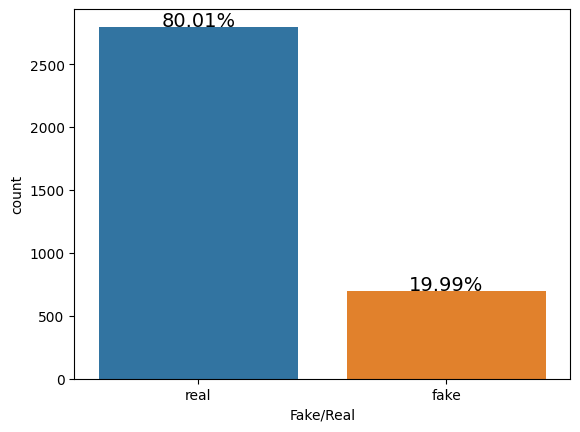

In [22]:
# lets see the distribution of the data, is it balanced?
s = sns.countplot(x = 'Fake/Real',data = data_B)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(data_B)*100),
            ha="center", fontsize=14)

We can observe that the dataset is very unbalanced with the real labels corresponding to 80% of the data and the 20% left being fake. This makes it a challange when trianing as there could be a possibility that the splitting is not done correctly. We will have to stratify the data in order to have the same proportion in labels for training and validating/testing.

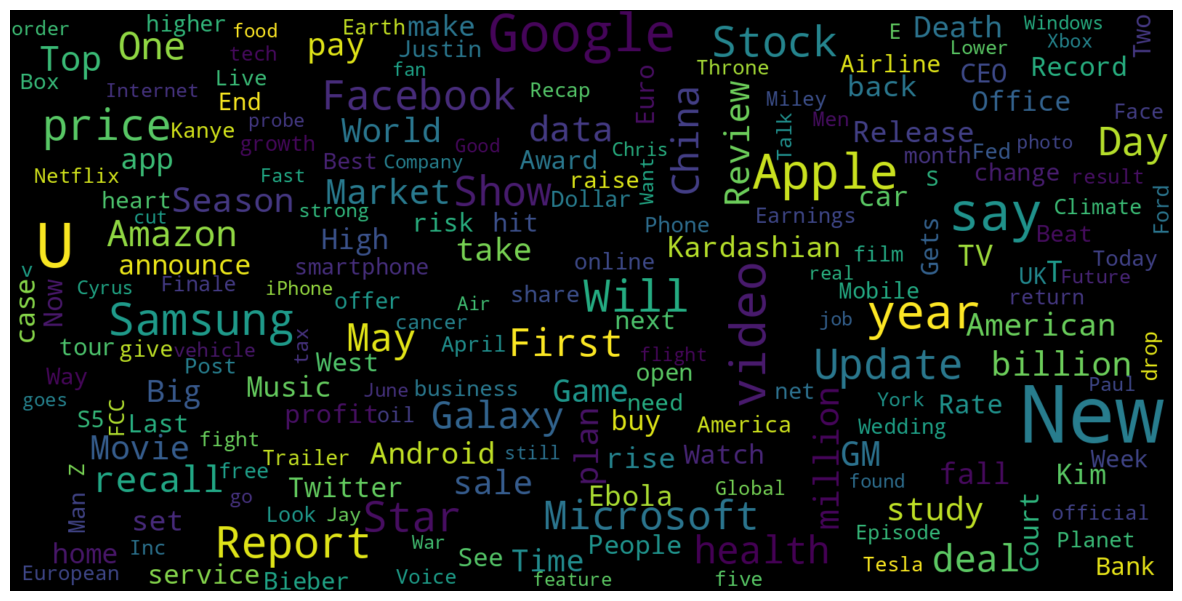

In [23]:
from wordcloud import WordCloud
# Real
consolidated_r = ' '.join(word for word in data_B['Title'][data_B['Fake/Real']== 'real'].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)

plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated_r), interpolation='bilinear')
plt.axis('off')
plt.show()

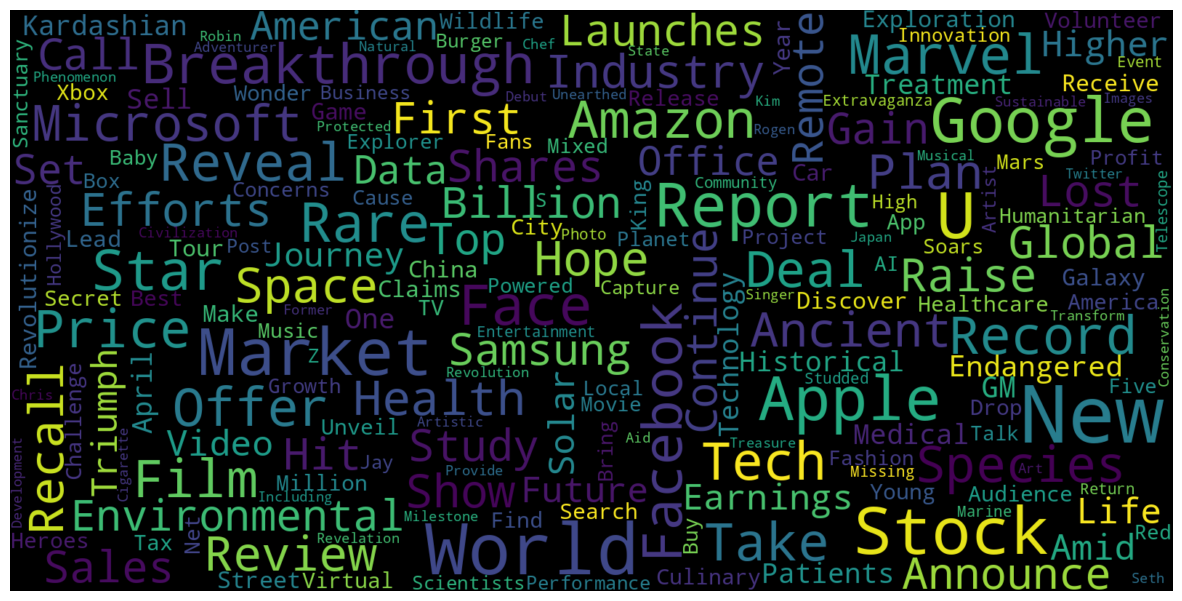

In [24]:
# Fake
consolidated_f = ' '.join(word for word in data_B['Title'][data_B['Fake/Real']== 'fake'].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)

plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated_f), interpolation='bilinear')
plt.axis('off')
plt.show()

n order to observe and gain insights from the data, we opted to generate word clouds that visualize word frequency across the two classes. A noticeable pattern emerged: the fake class exhibited a higher frequency of words, whereas the real class demonstrated a lower frequency, with words appearing smaller in the visualization. This suggests that the fake class tends to contain more repetitive words. This could be attributed to two factors: firstly, there is less fake data overall, leading to a reduced probability of diverse words appearing. Secondly, it's possible that the language model generating the data is biased toward using the same types of words, resulting in the generation of titles with repeated words.

## PREPROCESSING

In contrast with the previous problem, there was not much preprocessing to do with the data itself. The main challenge was to be able to extract important features from the text.

After observing the data, some patterns to distinguish between fake and real were very clar. Here are some of the features that we tried to extract:
* Having "" at the end and begginging of the sentence
* Having '...' at the end of the sentence
* Having '!' at any point in the sentence
* Counting the number of words
* Counting the number of letters
* Counting the number of words that start in Uppercase
* Couting the number of special characters (i.e, '/():$%' etc.)
* Counting numbers in the sentence


Lastly, we converted the string titles into a vectorized representation by employing the TfidfVectorizer from the scikit-learn library. This vectorizer considers the frequency of all words in the text, leading us to believe that it might provide valuable insights.

However, our observations revealed that the use of this vectorizer neither improved nor hindered our predictions. Instead, it significantly increased the number of features in the model. Therefore, for our final predictions, we made the deliberate choice not to use it in order to avoid issues related to the curse of dimensionality.

In [25]:
data_B_pre = data_B.copy()

#### Has Quotes (")

In [ ]:
# Use regular expressions to check if values in 'Title' start and end with "
data_B_pre['HasQuotes'] = data_B_pre['Title'].str.match(r'^".*"$').astype(float)
data_B_pre

,Title,Fake/Real,HasQuotes
0,"""Bonds' Liquidity Threat Highlighted by Deriva...",fake,1.0
1,Things to remember about Google and the right ...,real,0.0
2,Record Store Day 2014: Digital Spy's Top 10 Picks,fake,0.0
3,Young Adults on Parents' Health Plans Report B...,fake,0.0
4,CEO Mary Barra apologizes for GM's handling of...,real,0.0
...,...,...,...
3492,Updated: Our Post-Show Interview With Dancing ...,real,0.0
3493,4 Ways Google Can Help Indie Android App Devel...,real,0.0
3494,"""Sony's April 2014 NPD Response: PS4 Demand Co...",fake,1.0
3495,Apple vs. Samsung Patent Lawsuit Closing Argum...,real,0.0


#### Has exclamation (!)

In [ ]:
# Use regular expressions to check if values in 'Title' has !
data_B_pre['Has!'] = data_B_pre['Title'].str.contains(r'!').astype(float)
data_B_pre

,Title,Fake/Real,HasQuotes,Has!
0,"""Bonds' Liquidity Threat Highlighted by Deriva...",fake,1.0,0.0
1,Things to remember about Google and the right ...,real,0.0,0.0
2,Record Store Day 2014: Digital Spy's Top 10 Picks,fake,0.0,0.0
3,Young Adults on Parents' Health Plans Report B...,fake,0.0,0.0
4,CEO Mary Barra apologizes for GM's handling of...,real,0.0,0.0
...,...,...,...,...
3492,Updated: Our Post-Show Interview With Dancing ...,real,0.0,0.0
3493,4 Ways Google Can Help Indie Android App Devel...,real,0.0,0.0
3494,"""Sony's April 2014 NPD Response: PS4 Demand Co...",fake,1.0,0.0
3495,Apple vs. Samsung Patent Lawsuit Closing Argum...,real,0.0,0.0


### Number of words starting in uppercase

In [ ]:
# Function to count the number of words starting in uppercase
def count_words_starting_with_capital(text):
    words = text.split()  # Split the text into words
    return sum(1 for word in words if word.istitle())


data_B_pre['NumCapital'] = data_B_pre['Title'].apply(count_words_starting_with_capital).astype(float)
data_B_pre


,Title,Fake/Real,HasQuotes,Has!,NumCapital
0,"""Bonds' Liquidity Threat Highlighted by Deriva...",fake,1.0,0.0,6.0
1,Things to remember about Google and the right ...,real,0.0,0.0,2.0
2,Record Store Day 2014: Digital Spy's Top 10 Picks,fake,0.0,0.0,6.0
3,Young Adults on Parents' Health Plans Report B...,fake,0.0,0.0,8.0
4,CEO Mary Barra apologizes for GM's handling of...,real,0.0,0.0,2.0
...,...,...,...,...,...
3492,Updated: Our Post-Show Interview With Dancing ...,real,0.0,0.0,10.0
3493,4 Ways Google Can Help Indie Android App Devel...,real,0.0,0.0,10.0
3494,"""Sony's April 2014 NPD Response: PS4 Demand Co...",fake,1.0,0.0,6.0
3495,Apple vs. Samsung Patent Lawsuit Closing Argum...,real,0.0,0.0,8.0


### Having numbers

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
#nltk.download('punkt')


nltk.download('averaged_perceptron_tagger')

# Define important POS tags (e.g., NN for nouns, VB for verbs, CD for numbers)
important_pos_tags = ['CD']

# Check if numbers appear in the sentece
def check_numbers(row, important_pos_tags):
    sentence = row['Title']
    words = word_tokenize(sentence)
    pos_tags = pos_tag(words)

    for word, tag in pos_tags:
        if tag in important_pos_tags:
            return True

    return False

# Apply the function to each row in the DataFrame
data_B_pre['Numbers'] = data_B_pre.apply(lambda row: check_numbers(row, important_pos_tags), axis=1).astype(float)
data_B_pre

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Title,Fake/Real,HasQuotes,Has!,NumCapital,Numbers
0,"""Bonds' Liquidity Threat Highlighted by Deriva...",fake,1.0,0.0,6.0,0.0
1,Things to remember about Google and the right ...,real,0.0,0.0,2.0,0.0
2,Record Store Day 2014: Digital Spy's Top 10 Picks,fake,0.0,0.0,6.0,1.0
3,Young Adults on Parents' Health Plans Report B...,fake,0.0,0.0,8.0,0.0
4,CEO Mary Barra apologizes for GM's handling of...,real,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...
3492,Updated: Our Post-Show Interview With Dancing ...,real,0.0,0.0,10.0,0.0
3493,4 Ways Google Can Help Indie Android App Devel...,real,0.0,0.0,10.0,1.0
3494,"""Sony's April 2014 NPD Response: PS4 Demand Co...",fake,1.0,0.0,6.0,1.0
3495,Apple vs. Samsung Patent Lawsuit Closing Argum...,real,0.0,0.0,8.0,0.0


### Has Proper Nouns

In [ ]:
# Define important POS tags (e.g., NN for nouns, VB for verbs)
important_pos_tags = ['NNP', 'NNPS'] # for proper nouns


def proper_noun(row, important_pos_tags):
    sentence = row['Title']
    words = word_tokenize(sentence)
    pos_tags = pos_tag(words)

    for word, tag in pos_tags:
        if tag in important_pos_tags:
            return True

    return False

# Apply the function to each row in the DataFrame
data_B_pre['ProperNoun'] = data_B_pre.apply(lambda row: proper_noun(row, important_pos_tags), axis=1).astype(float)
data_B_pre

,Title,Fake/Real,HasQuotes,Has!,NumCapital,Numbers,CountLetter,ProperNoun
0,"""Bonds' Liquidity Threat Highlighted by Deriva...",fake,1.0,0.0,6.0,0.0,62,1.0
1,Things to remember about Google and the right ...,real,0.0,0.0,2.0,0.0,61,1.0
2,Record Store Day 2014: Digital Spy's Top 10 Picks,fake,0.0,0.0,6.0,1.0,49,1.0
3,Young Adults on Parents' Health Plans Report B...,fake,0.0,0.0,8.0,0.0,58,1.0
4,CEO Mary Barra apologizes for GM's handling of...,real,0.0,0.0,2.0,0.0,53,1.0
...,...,...,...,...,...,...,...,...
3492,Updated: Our Post-Show Interview With Dancing ...,real,0.0,0.0,10.0,0.0,77,1.0
3493,4 Ways Google Can Help Indie Android App Devel...,real,0.0,0.0,10.0,1.0,63,1.0
3494,"""Sony's April 2014 NPD Response: PS4 Demand Co...",fake,1.0,0.0,6.0,1.0,73,1.0
3495,Apple vs. Samsung Patent Lawsuit Closing Argum...,real,0.0,0.0,8.0,0.0,66,1.0


The problem with this feature is that it was hard to obtain a database that had all the Proper Nouns (noms propis) that we needed, in some cases (i.e. company names) this function is not able to identfy correctly the proper noun.

### Count Letters

In [ ]:
# Apply the function to the 'Title' column, and counf the number of letters in each title
data_B_pre['CountLetter'] = data_B_pre['Title'].apply(lambda x: len(x))
data_B_pre

,Title,Fake/Real,HasQuotes,Has!,NumCapital,Numbers,CountLetter
0,"""Bonds' Liquidity Threat Highlighted by Deriva...",fake,1.0,0.0,6.0,0.0,62
1,Things to remember about Google and the right ...,real,0.0,0.0,2.0,0.0,61
2,Record Store Day 2014: Digital Spy's Top 10 Picks,fake,0.0,0.0,6.0,1.0,49
3,Young Adults on Parents' Health Plans Report B...,fake,0.0,0.0,8.0,0.0,58
4,CEO Mary Barra apologizes for GM's handling of...,real,0.0,0.0,2.0,0.0,53
...,...,...,...,...,...,...,...
3492,Updated: Our Post-Show Interview With Dancing ...,real,0.0,0.0,10.0,0.0,77
3493,4 Ways Google Can Help Indie Android App Devel...,real,0.0,0.0,10.0,1.0,63
3494,"""Sony's April 2014 NPD Response: PS4 Demand Co...",fake,1.0,0.0,6.0,1.0,73
3495,Apple vs. Samsung Patent Lawsuit Closing Argum...,real,0.0,0.0,8.0,0.0,66


### Count words

In [ ]:
from nltk.tokenize import sent_tokenize

# Function to calculate sentence length (in words)
def sentence_length(text):
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    for sentence in sentences:

      return float(len(sentence.split()))

# Apply the function to the 'Text' column
data_B_pre['CountWords'] = data_B_pre['Title'].apply(sentence_length)
data_B_pre

,Title,Fake/Real,HasQuotes,Has!,NumCapital,Numbers,CountLetter,ProperNoun,CountWords
0,"""Bonds' Liquidity Threat Highlighted by Deriva...",fake,1.0,0.0,6.0,0.0,62,1.0,7.0
1,Things to remember about Google and the right ...,real,0.0,0.0,2.0,0.0,61,1.0,11.0
2,Record Store Day 2014: Digital Spy's Top 10 Picks,fake,0.0,0.0,6.0,1.0,49,1.0,9.0
3,Young Adults on Parents' Health Plans Report B...,fake,0.0,0.0,8.0,0.0,58,1.0,9.0
4,CEO Mary Barra apologizes for GM's handling of...,real,0.0,0.0,2.0,0.0,53,1.0,9.0
...,...,...,...,...,...,...,...,...,...
3492,Updated: Our Post-Show Interview With Dancing ...,real,0.0,0.0,10.0,0.0,77,1.0,12.0
3493,4 Ways Google Can Help Indie Android App Devel...,real,0.0,0.0,10.0,1.0,63,1.0,11.0
3494,"""Sony's April 2014 NPD Response: PS4 Demand Co...",fake,1.0,0.0,6.0,1.0,73,1.0,11.0
3495,Apple vs. Samsung Patent Lawsuit Closing Argum...,real,0.0,0.0,8.0,0.0,66,1.0,9.0


### Count special characters

In [ ]:
import re

# Define a regular expression pattern to match special characters
pattern = r'[^"!...a-zA-Z0-9\s]'

# Function to count special characters in a sentence
def count_special_characters(sentence):
    special_characters = re.findall(pattern, sentence)
    #print(special_characters)
    return float(len(special_characters))

data_B_pre['SpecialCharacters'] = data_B_pre['Title'].apply(count_special_characters)
data_B_pre

,Title,Fake/Real,HasQuotes,Has!,NumCapital,Numbers,CountLetter,ProperNoun,CountWords,SpecialCharacters
0,"""Bonds' Liquidity Threat Highlighted by Deriva...",fake,1.0,0.0,6.0,0.0,62,1.0,7.0,1.0
1,Things to remember about Google and the right ...,real,0.0,0.0,2.0,0.0,61,1.0,11.0,0.0
2,Record Store Day 2014: Digital Spy's Top 10 Picks,fake,0.0,0.0,6.0,1.0,49,1.0,9.0,2.0
3,Young Adults on Parents' Health Plans Report B...,fake,0.0,0.0,8.0,0.0,58,1.0,9.0,1.0
4,CEO Mary Barra apologizes for GM's handling of...,real,0.0,0.0,2.0,0.0,53,1.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...
3492,Updated: Our Post-Show Interview With Dancing ...,real,0.0,0.0,10.0,0.0,77,1.0,12.0,2.0
3493,4 Ways Google Can Help Indie Android App Devel...,real,0.0,0.0,10.0,1.0,63,1.0,11.0,0.0
3494,"""Sony's April 2014 NPD Response: PS4 Demand Co...",fake,1.0,0.0,6.0,1.0,73,1.0,11.0,2.0
3495,Apple vs. Samsung Patent Lawsuit Closing Argum...,real,0.0,0.0,8.0,0.0,66,1.0,9.0,0.0


### Has ellipses (...)

In [ ]:
# Function to check for ellipses at the end of a title
def has_ellipsis(title):
    return title.endswith("...")

# Apply the function to create a new feature 'HasEllipsis'
data_B_pre['HasEllipsis'] = data_B_pre['Title'].apply(has_ellipsis).astype(float)  # Convert boolean to 0 or 1

# Display the DataFrame with the new feature
data_B_pre

,Title,Fake/Real,HasQuotes,Has!,NumCapital,Numbers,CountLetter,ProperNoun,CountWords,SpecialCharacters,HasEllipsis
0,"""Bonds' Liquidity Threat Highlighted by Deriva...",fake,1.0,0.0,6.0,0.0,62,1.0,7.0,1.0,0.0
1,Things to remember about Google and the right ...,real,0.0,0.0,2.0,0.0,61,1.0,11.0,0.0,0.0
2,Record Store Day 2014: Digital Spy's Top 10 Picks,fake,0.0,0.0,6.0,1.0,49,1.0,9.0,2.0,0.0
3,Young Adults on Parents' Health Plans Report B...,fake,0.0,0.0,8.0,0.0,58,1.0,9.0,1.0,0.0
4,CEO Mary Barra apologizes for GM's handling of...,real,0.0,0.0,2.0,0.0,53,1.0,9.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3492,Updated: Our Post-Show Interview With Dancing ...,real,0.0,0.0,10.0,0.0,77,1.0,12.0,2.0,1.0
3493,4 Ways Google Can Help Indie Android App Devel...,real,0.0,0.0,10.0,1.0,63,1.0,11.0,0.0,0.0
3494,"""Sony's April 2014 NPD Response: PS4 Demand Co...",fake,1.0,0.0,6.0,1.0,73,1.0,11.0,2.0,0.0
3495,Apple vs. Samsung Patent Lawsuit Closing Argum...,real,0.0,0.0,8.0,0.0,66,1.0,9.0,0.0,0.0


### TFID vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

In [ ]:
# Convert the TF-IDF matrix to a Pandas DataFrame (optional)
df = pd.DataFrame(tfidf_vectorizer.fit_transform(data_B_pre['Title']).toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Print the TF-IDF vectors
print(df)

       00  000  0160   03   04   05   07   08   0b  0day  ...  zillow  zoe  \
0     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...     0.0  0.0   
1     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...     0.0  0.0   
2     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...     0.0  0.0   
3     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...     0.0  0.0   
4     0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...     0.0  0.0   
...   ...  ...   ...  ...  ...  ...  ...  ...  ...   ...  ...     ...  ...   
3492  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...     0.0  0.0   
3493  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...     0.0  0.0   
3494  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...     0.0  0.0   
3495  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...     0.0  0.0   
3496  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  ...     0.0  0.0   

      zone  zones  zoo  zoom  zoomable  zooms  zuckerberg  zyng

In [ ]:
data_B_all = pd.concat([df, pd.DataFrame(data_B_pre)], axis = 1)
data_B_all

,00,000,0160,03,04,05,07,08,0b,0day,...,Fake/Real,HasQuotes,Has!,NumCapital,Numbers,CountLetter,ProperNoun,CountWords,SpecialCharacters,HasEllipsis
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,fake,1.0,0.0,6.0,0.0,62,1.0,7.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,real,0.0,0.0,2.0,0.0,61,1.0,11.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,fake,0.0,0.0,6.0,1.0,49,1.0,9.0,2.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,fake,0.0,0.0,8.0,0.0,58,1.0,9.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,real,0.0,0.0,2.0,0.0,53,1.0,9.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,real,0.0,0.0,10.0,0.0,77,1.0,12.0,2.0,1.0
3493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,real,0.0,0.0,10.0,1.0,63,1.0,11.0,0.0,0.0
3494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,fake,1.0,0.0,6.0,1.0,73,1.0,11.0,2.0,0.0
3495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,real,0.0,0.0,8.0,0.0,66,1.0,9.0,0.0,0.0


As we can see, we are left with a dataframe of 7480 features, it is probabily too big of a dataframe and course of dimentionality could be happening. After training with and without the vectorizer and observing no big changes in the performance, we decided to discard this approach.

### CONCLUSIONS

After creating several functions for the creation of features, we tested several combinations of them for the training and prediction process. Some features were very informative whereas others where not.

Informative features:
* Having "" --> at the end and begginging of the sentence (only FAKE have it)
* Having ... --> at the end of the sentence (only REAL have it)
* Having !   --> at some point (only REAL have it)

Non-informative features:
* Having Proper Nouns --> probably beacuse of programming difficulties and the fact that we did not have a good database

The other features were not as crucial, but we think that they do have some importance in the prediction and further more with not overffiting in the training set.

## MODELS

Similar to Problem A, we opted to experiment with various fundamental classifiers to assess their performance while incorporating the diverse features mentioned earlier.

As we have seen in the analysis of the data, we are facing a very unbalanced dataset so it was crucial to stratify the triaining and test datasets.

Additionally, in our pursuit of model improvement, we also tried fine-tuning the parameters using Grid Search. However, we encountered a challenge; our models exhibited signs of overfitting. Thus, we have omitted the code for this latter part, as it ultimately led to a reduction in test performance.


In [ ]:
### Selecting the features
data_B_all_selected = data_B_all[['Fake/Real', 'HasQuotes', 'Has!', 'HasEllipsis']]
data_B_all_selected

,Fake/Real,HasQuotes,Has!,HasEllipsis
0,fake,1.0,0.0,0.0
1,real,0.0,0.0,0.0
2,fake,0.0,0.0,0.0
3,fake,0.0,0.0,0.0
4,real,0.0,0.0,0.0
...,...,...,...,...
3492,real,0.0,0.0,1.0
3493,real,0.0,0.0,0.0
3494,fake,1.0,0.0,0.0
3495,real,0.0,0.0,0.0


### Splitting the data

In [ ]:
from sklearn.model_selection import train_test_split
X = data_B_all_selected.drop('Fake/Real', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X),
                                                    data_B_all_selected['Fake/Real'],
                                                    test_size=0.25, stratify=data_B_all_selected['Fake/Real'])

2622


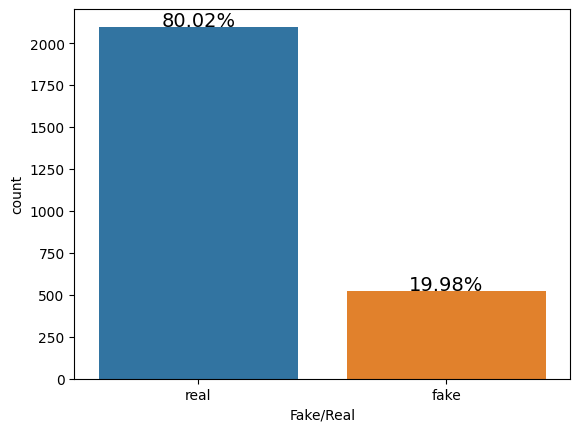

In [ ]:
data = pd.concat([X_train, y_train], axis = 1)
print(len(data))
s = sns.countplot(x = 'Fake/Real',data = data)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(data)*100),
            ha="center", fontsize=14)

Here we can see that the training dataset consist of 2622 rows with the same proportion in classes as in the original data.

### Training different models

Again, because of the unbalance in the data we have not focused our selection of the model only on the accuracy performance but also in the F1-score, thus, for each model we have printed the classification report as well as the confusion matrix for some of them.

In [ ]:
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
##  Logistic Regression
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)

# testing the model
print('Training Accuracy:', accuracy_score(y_train, model_lr.predict(X_train)))
print('Validation Accuracy:', accuracy_score(y_test, model_lr.predict(X_test)))
print(classification_report(y_test, pred_lr, target_names=['Fake', 'Real']))

Training Accuracy: 0.9610983981693364
Validation Accuracy: 0.9611428571428572
              precision    recall  f1-score   support

        Fake       1.00      0.81      0.89       175
        Real       0.95      1.00      0.98       700

    accuracy                           0.96       875
   macro avg       0.98      0.90      0.93       875
weighted avg       0.96      0.96      0.96       875



In [ ]:
##  Logistic Regression with regularization
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', C=2.0)
model.fit(X_train, y_train)
pred_lr = model_lr.predict(X_test)

# testing the model
print('Training Accuracy:', accuracy_score(y_train, model.predict(X_train)))
print('Validation Accuracy:', accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, pred_lr, target_names=['Fake', 'Real']))

Training Accuracy: 0.9610983981693364
Validation Accuracy: 0.9611428571428572
              precision    recall  f1-score   support

        Fake       1.00      0.81      0.89       175
        Real       0.95      1.00      0.98       700

    accuracy                           0.96       875
   macro avg       0.98      0.90      0.93       875
weighted avg       0.96      0.96      0.96       875



In [ ]:
## Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

clf_MNB = MultinomialNB(force_alpha=True)
clf_MNB.fit(X_train, y_train)
pred_MNB = clf_MNB.predict(X_test)

# testing the model
print('Training Accuracy new col + Tf ID vectorized:', accuracy_score(y_train, clf_MNB.predict(X_train)))
print('Validation Accuracy new col + Tf ID vectorized:', accuracy_score(y_test, clf_MNB.predict(X_test)))
print(classification_report(y_test, pred_MNB, target_names=['Fake', 'Real']))

Training Accuracy new col + Tf ID vectorized: 0.9610983981693364
Validation Accuracy new col + Tf ID vectorized: 0.9611428571428572
              precision    recall  f1-score   support

        Fake       1.00      0.81      0.89       175
        Real       0.95      1.00      0.98       700

    accuracy                           0.96       875
   macro avg       0.98      0.90      0.93       875
weighted avg       0.96      0.96      0.96       875



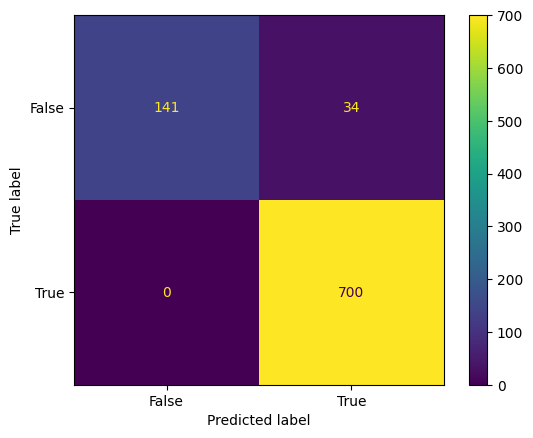

In [ ]:
# Confusion matrix of Results from MNB
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, pred_MNB)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()

In [ ]:
## lets train with decision tree classifier

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
pred = model.predict(X_test)

# testing the model
print('Training Accuracy new col + TF ID vectorized:', accuracy_score(y_train, model.predict(X_train)))
print('Validation Accuracy new col + TF ID vectorized:', accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, pred, target_names=['Fale', 'Real']))

Training Accuracy new col + TF ID vectorized: 0.9610983981693364
Validation Accuracy new col + TF ID vectorized: 0.9611428571428572
              precision    recall  f1-score   support

        Fale       1.00      0.81      0.89       175
        Real       0.95      1.00      0.98       700

    accuracy                           0.96       875
   macro avg       0.98      0.90      0.93       875
weighted avg       0.96      0.96      0.96       875



In [ ]:
## Random tree
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
# testing the model
print('Training Accuracy new col +  TF ID vectorized:', accuracy_score(y_train, clf.predict(X_train)))
print('Validation Accuracy new_col + TF ID vectorized:', accuracy_score(y_test, clf.predict(X_test)))
print(classification_report(y_test, pred, target_names=['Fale', 'Real']))

Training Accuracy new col +  TF ID vectorized: 0.9610983981693364
Validation Accuracy new_col + TF ID vectorized: 0.9611428571428572
              precision    recall  f1-score   support

        Fale       1.00      0.81      0.89       175
        Real       0.95      1.00      0.98       700

    accuracy                           0.96       875
   macro avg       0.98      0.90      0.93       875
weighted avg       0.96      0.96      0.96       875



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=11))]
)

clf = KNeighborsClassifier(n_neighbors=14)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# testing the model
print('Training Accuracy new col + TF ID vecotrized:', accuracy_score(y_train, clf.predict(X_train)))
print('Validation Accuracy new col + TF ID vecotrized:', accuracy_score(y_test, clf.predict(X_test)))
print(classification_report(y_test, pred, target_names=['Fale', 'Real']))

Training Accuracy new col + TF ID vecotrized: 0.9610983981693364
Validation Accuracy new col + TF ID vecotrized: 0.9611428571428572
              precision    recall  f1-score   support

        Fale       1.00      0.81      0.89       175
        Real       0.95      1.00      0.98       700

    accuracy                           0.96       875
   macro avg       0.98      0.90      0.93       875
weighted avg       0.96      0.96      0.96       875



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

clf_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
# testing the model
pred_GB = clf_GB.predict(X_test)
print('Training Accuracy new col + tf id vectorized:', accuracy_score(y_train, clf_GB.predict(X_train)))
print('Validation Accuracy new col + tf id vectorized:', accuracy_score(y_test, clf_GB.predict(X_test)))
print(classification_report(y_test, pred_GB, target_names=['Fale', 'Real']))

Training Accuracy new col + tf id vectorized: 0.9610983981693364
Validation Accuracy new col + tf id vectorized: 0.9611428571428572
              precision    recall  f1-score   support

        Fale       1.00      0.81      0.89       175
        Real       0.95      1.00      0.98       700

    accuracy                           0.96       875
   macro avg       0.98      0.90      0.93       875
weighted avg       0.96      0.96      0.96       875



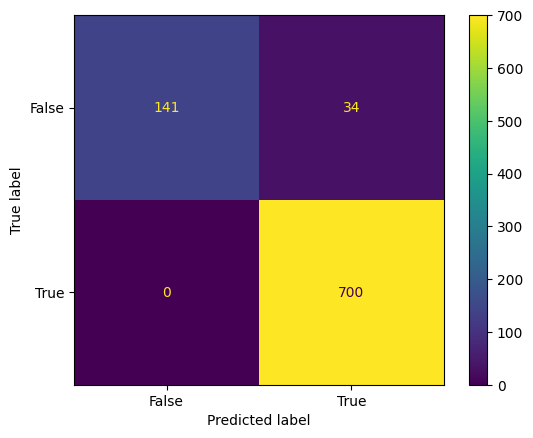

In [ ]:
# Confusion matrix of Results from GB
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, pred_GB)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

clf_HG = HistGradientBoostingClassifier()
clf_HG.fit(X_train, y_train)
pred_HG = clf_HG.predict(X_test)

# testing the model
print('Training Accuracy new col + tf id vectorized:', accuracy_score(y_train, clf_HG.predict(X_train)))
print('Validation Accuracy new col + tf id vectorized:', accuracy_score(y_test, clf_HG.predict(X_test)))
print(classification_report(y_test, pred_HG, target_names=['Fale', 'Real']))

Training Accuracy new col + tf id vectorized: 0.9610983981693364
Validation Accuracy new col + tf id vectorized: 0.9611428571428572
              precision    recall  f1-score   support

        Fale       1.00      0.81      0.89       175
        Real       0.95      1.00      0.98       700

    accuracy                           0.96       875
   macro avg       0.98      0.90      0.93       875
weighted avg       0.96      0.96      0.96       875



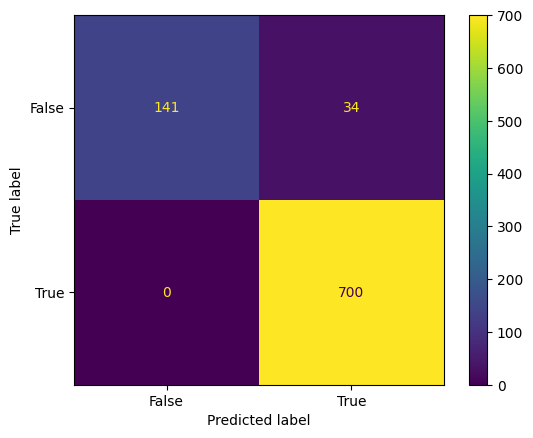

In [ ]:
# Confusion matrix
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, pred_HG)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
											display_labels=[False, True])

cm_display.plot()
plt.show()

### CONCLUSIONS

Considering the assessment of various feature combinations, the models that consistently demonstrated superior performance were Multinomial Naive Bayes, Logistic Regression, or the Gradient Boosting algorithms.

During our experiments, we frequently encountered instances of overfitting, which suggests that our trained models may be overly tailored to our training data, potentially resulting in suboptimal generalization when applied to submissions.

While it's possible that we could have explored additional models or different sets of features, we observed that the overall performance remained relatively stable, with minimal significant improvements.

## SUBMISSIONS

For our submissions, we wold just applay the same transformations to the test data set and then use the better performing model to predict each label.

## TAKE HOME IDEAS

To sum up, this is the process that we have followed:

1.   **Pre analysis of the data**, where we have observe that the main problem of this data set is the need of important **feature extraction**.
2.   **Preprocessing of the data**, where we have dealt with creating different functions in order to extract features from text data. Concluding with some of the most important features being 'Having ""', 'Having ...', or 'Number of words'. Here we have observed that having more features does not mean better performance.

   We have also tried to **vectorize**  the data using a pre-defined function from skitlearn, but the overall performance was not being dependent on it and one of the main downfalls is that it was adding to many features to the model.

3.  **Model selection**, where we tested **different classifiers** and compared them using a **validation set**. We also used a grid search to improve the performance of the models by **fine tuning** its paremeters, although we observed overfitting when doing so.

TAKE HOME IDEAS:

*   It is hard to extract meaningful features from text data.
*   Once again, sometimes, a simplier approach is better than more difficult ones (like not needing a vectorizer, if the features have been well selected).
*   Unbalanced datasets have to be treated differently, it is important to keep the balance in the training and test sets, as well as measuring the performance of the models with different metrics such as F1 score or plotting the confusion matrix.
*   Fine tuning the model can really help improving its performance but it can also cause overfitting to the training set.
*  Projects like this one are really time-consuming since we tried to test every possible combination for every litte change we made. For this it is important to have domain knowdlege on the data.

# SOME FINAL CONCLUSIONS OF THE COMPETITION

- Having good data is crucial to be able to perform correclty a ML task.
- The pre-preocessing stage is a key part of the ML process as introducing bias could have big reprecussions further on.
- ML process does not only consist on applying a classifier or a model but much more, such as being able to understand the problem as well as the data.

- Although LLM is a very good tool for generation porpuses, classic classification algorithms are able to distinguish between real data and LLM generated data, up until a point.

  In the 2nd problem some patterns form LLM where very clear such as the use of "". Nevertheless, semantically, the generation of the text data is nearly perfect.

- This project has helped learn a lot on the hands-one side of machine learning. We have improved our programming skills as most of the time we have spent programming in the preprocessing stage.